# Datathon Mayo 2018  **_"Haciendo el gasto fiscal visible para el público"_**
## Gasto Neto Mensualizado por año de las Instituciones Públicas

## Lectura de Datos

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import pandas_profiling as pd_profiling
import altair as alt

In [2]:
def read_field_type(x):
    '''
    Para facilitar la lectura de los dataframes con los tipos de columna correspondientes.
    '''
    if x in ['String']:
        return str
    elif x in ['Integer', 'Long']:
        return int
    else:
        return str

In [3]:
pub_spend_names = pd.read_csv(os.path.join('data', 
                              'dataset_1_monthly_spend_2009-2017_DICTIONARY.csv'), 
                              sep=';', 
                              encoding='utf-8')

In [4]:
pub_spend_names

,Field name,Field type,Field size,Field format,Range,Description,Example
0,Periodo,Integer,15,#,2009 to 2017,Year of the spend,2009
1,Nombre Partida,String,63,NaN,28 categories,Ministeries,Ministerio de Educación
2,Nombre Capitulo,String,78,NaN,219 categories,Public Services,Fondo Nacional de Salud
3,Nombre Programa,String,78,NaN,363 categories,Programs,Fondo Nacional de Salud
4,Nombre Subtitulo,String,37,NaN,10 categories,First level of the budget classification,TRANSFERENCIAS CORRIENTES
5,Nombre Item,String,54,NaN,43 categories,Second level of the budget classification,Al Sector Privado
6,Nombre Asignación,String,250,NaN,4372 categories,Third level of the budget classification,Subsidios Fondo Solidario de Vivienda
7,Nombre SubAsignación,String,80,NaN,1355 categories,Last level of the budget classification,Asistencia Técnica
8,Mes,String,10,NaN,12 categories,Month,enero
9,Monto,Integer,15,#,(-49702217) to 357607483,"Amount, this data was update by the inflation ...",357607483


In [5]:
pub_spend = pd.read_csv(os.path.join('data', 
                              'dataset_1_monthly_spend_2009-2017.csv'),
                 sep=';', 
                 encoding='utf-8',
                 dtype=dict(zip(pub_spend_names['Field name'], pub_spend_names['Field type'].apply(read_field_type))))

In [6]:
pub_spend.head(5) 

,Periodo,Nombre Partida,Nombre Capitulo,Nombre Programa,Nombre Subtitulo,Nombre Item,Nombre Asignación,Nombre SubAsignación,Mes,Monto_sum
0,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Abril,0
1,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Agosto,0
2,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Diciembre,0
3,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Enero,0
4,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Febrero,0


In [7]:
pub_spend.columns = ['periodo', 'partida', 'capitulo', 'programa', 'subtitulo', 'item', 'asignacion', 'subasignacion', 'mes', 'gasto']

In [8]:
pub_spend.shape

(3110448, 10)

In [9]:
pub_spend = pub_spend[pub_spend['gasto'] != 0]

In [10]:
pub_spend.shape

(2107310, 10)

In [11]:
pub_spend = pub_spend.sample(frac=0.2, random_state=42)

In [12]:
pub_spend.shape

(421462, 10)

In [13]:
sys.getsizeof(pub_spend) / 1024 / 1024.0

285.0831823348999

# Estadística descriptiva

In [14]:
alt.data_transformers.enable('json')
# alt.data_transformers.enable('default', max_rows=10000)

DataTransformerRegistry.enable('json')

## Gasto anual

In [15]:
es_month_dict = {'enero': 1,
                 'febrero': 2,
                 'marzo': 3, 
                 'abril': 4,
                 'mayo': 5,
                 'junio': 6,
                 'julio': 7,
                 'agosto': 8,
                 'septiembre': 9,
                 'octubre': 10,
                 'noviembre': 11,
                 'diciembre': 12
                }

In [16]:
pub_spend['month'] = pub_spend['mes'].str.lower().map(es_month_dict)
pub_spend['day'] = 15

In [17]:
pub_spend['date'] = pd.to_datetime(pub_spend[['day', 'month', 'periodo']].rename(columns={'periodo': 'year'}))

In [18]:
pub_spend.drop(['periodo', 'mes', 'month', 'day'], axis=1, inplace=True)

In [19]:
for col in pub_spend:
    print(f'{col}: { sys.getsizeof(pub_spend[col]) / 1024 / 1024.0} - {pub_spend[col].dtype}')

partida: 41.603678703308105 - object
capitulo: 45.84560680389404 - object
programa: 45.35816764831543 - object
subtitulo: 36.37845516204834 - object
item: 36.56552982330322 - object
asignacion: 38.751845359802246 - object
subasignacion: 27.921737670898438 - object
gasto: 6.431022644042969 - int64
date: 6.431022644042969 - datetime64[ns]


## Gasto Anual

In [20]:
pub_spend_chart = alt.Chart(pub_spend).mark_line().encode(
    x=alt.X('date:T', 
        timeUnit='year',
        axis=alt.Axis( title='Year')
           ),
    y='sum(gasto)',
).properties( 
    width=600, 
    height=400 
)

In [ ]:
pub_spend_chart

## Gasto Año-Mes

In [ ]:
pub_spend_chart.encode(
    x=alt.X('date:T', 
            timeUnit='yearmonth',
            axis=alt.Axis( title='Year-Month')
           )
)

## Gasto por Partida y Año

In [ ]:
pub_spend_chart.mark_bar().encode(
    x=alt.X('sum(gasto)'),
    y='partida:N',
    color=alt.Color('date:N', 
            timeUnit='year')
)

## Gasto Anual por Partida

In [ ]:
pub_spend_chart.encode(
    x=alt.X('date:T', 
            timeUnit='year',
            axis=alt.Axis( title='Year')
           ),
    color='partida:N',
)

## Gasto Mensual por Partida en cada Año

In [ ]:
pub_spend_chart.encode(
    x=alt.X('date:T', 
            timeUnit='month',
            axis=alt.Axis( title='Month')
           ),
    color='partida:N',
    row=alt.Row('date:T', 
            timeUnit='year'
           ),
)

## Conteo de registros vs Gasto

### Por Partida

In [21]:
aux_line = pub_spend_chart.encode(
    x=alt.X('date:T', 
            timeUnit='year',
            axis=alt.Axis( title='Month')
           ),
    y='count()',
    color='partida:N',
)

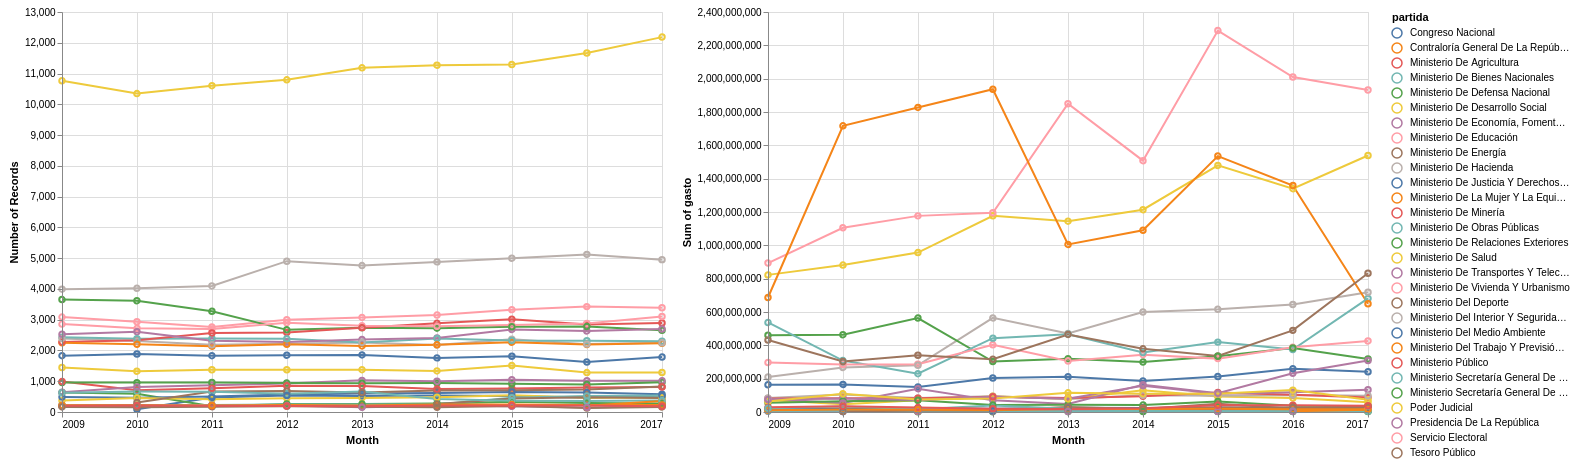

In [28]:
aux_line + aux_line.mark_point() | aux_line.encode(y='sum(gasto):Q') + aux_line.mark_point().encode(y='sum(gasto):Q')

### Por capítulo

In [ ]:
# aux_line.encode(color='capitulo') + aux_line.mark_point().encode(color='capitulo')

### Por Subtítulo

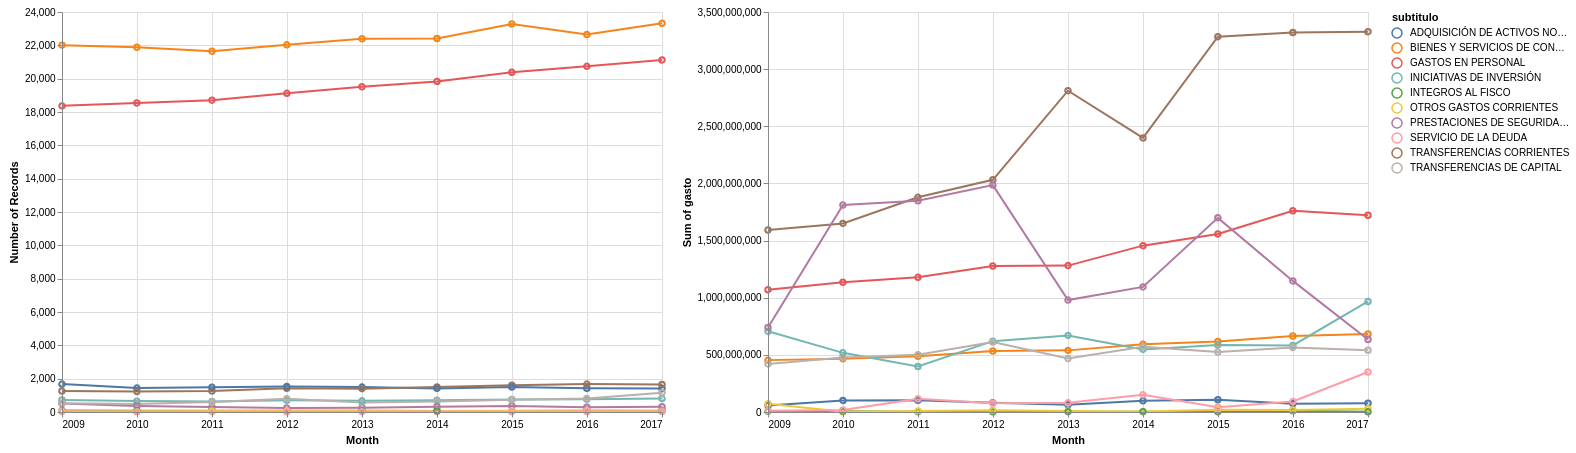

In [26]:
aux_line.encode(color='subtitulo') + aux_line.mark_point().encode(color='subtitulo') | aux_line.encode(y='sum(gasto):Q', color='subtitulo') + aux_line.mark_point().encode(y='sum(gasto):Q', color='subtitulo')

### Por Item

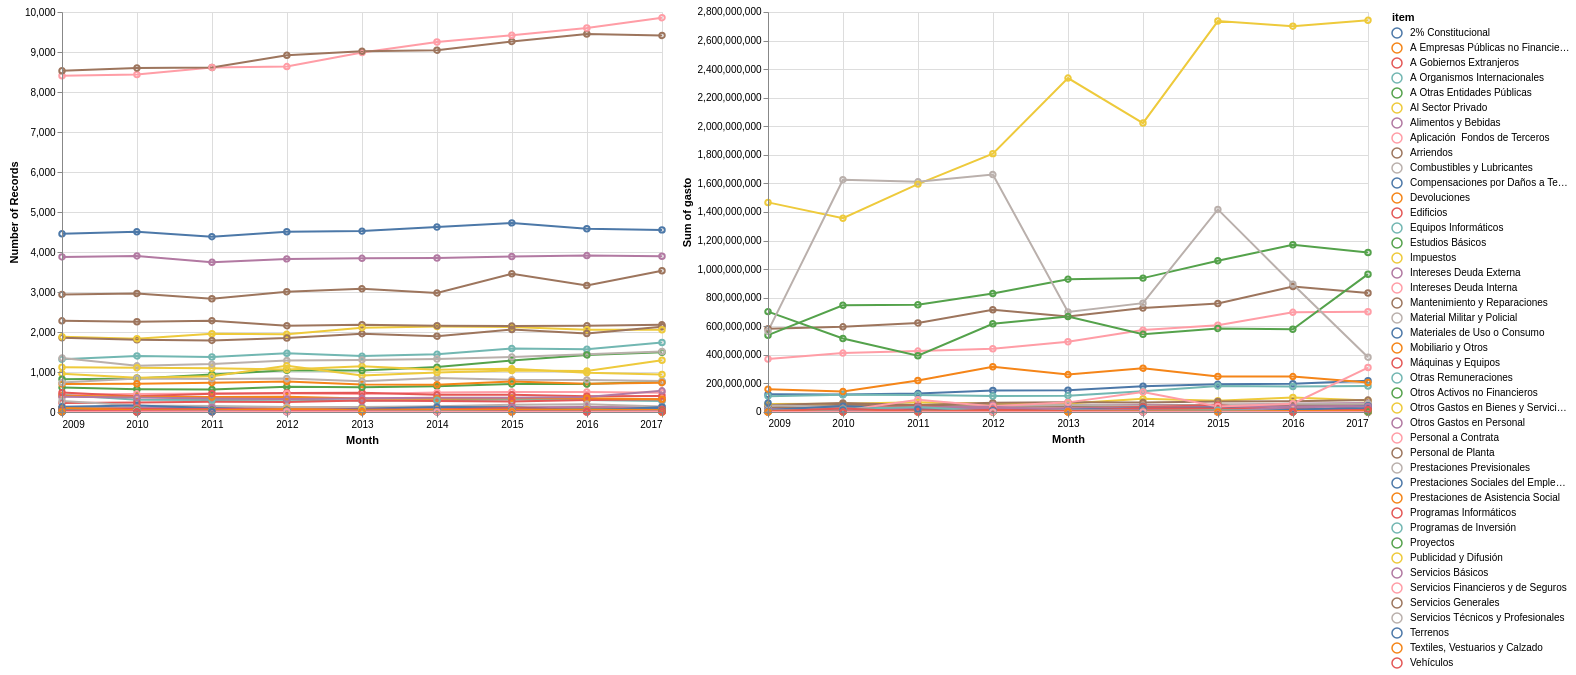

In [27]:
aux_line.encode(color='item') + aux_line.mark_point().encode(color='item') | aux_line.encode(y='sum(gasto):Q', color='item') + aux_line.mark_point().encode(y='sum(gasto):Q', color='item')

# Perfil por Partida

In [42]:
partida_name = 'Ministerio De Educación'

In [43]:
partida = pub_spend[pub_spend['partida'] == partida_name]

In [55]:
partida_chart = alt.Chart(partida).mark_line().encode(
    x=alt.X('date:T', 
            timeUnit='year',
            axis=alt.Axis( title='Year')
           ),
    y='sum(gasto):Q',
).properties(
    width=600,
    height=400,
)

## Quién gasta

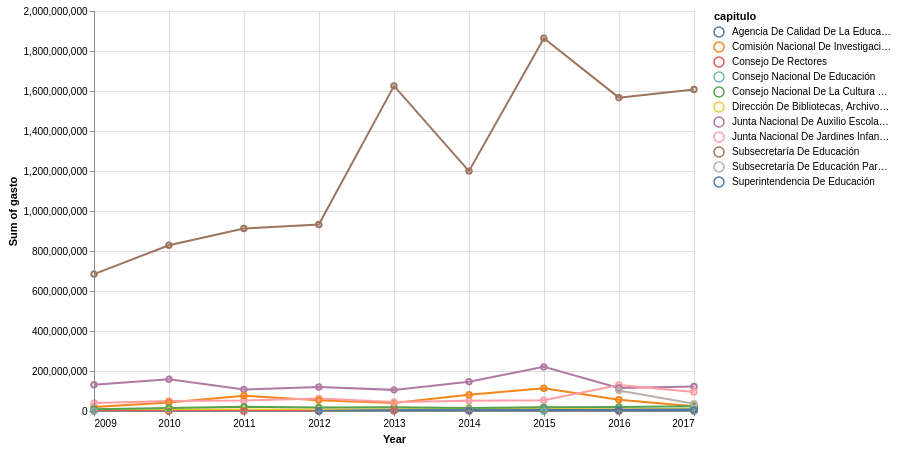

In [56]:
partida_chart.encode(color='capitulo:N') + partida_chart.mark_point().encode(color='capitulo:N') 

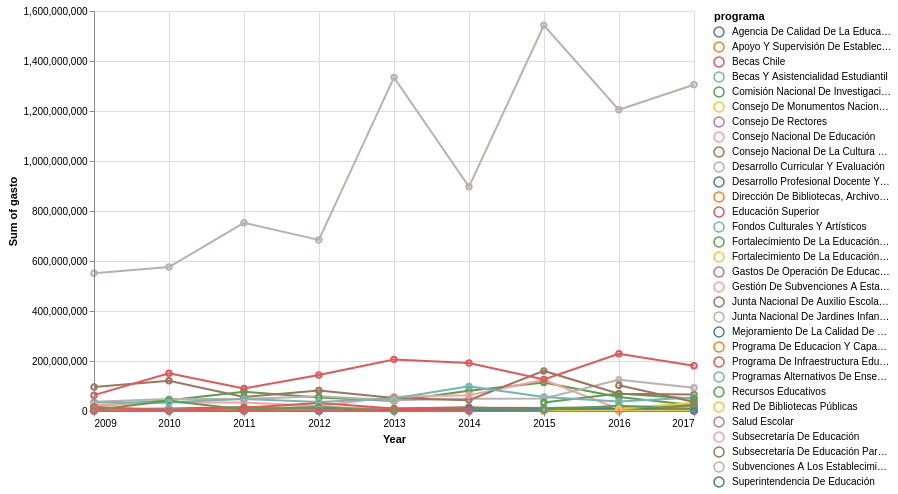

In [58]:
partida_chart.encode(color='programa:N') + partida_chart.mark_point().encode(color='programa:N') 

## Cómo se gasta

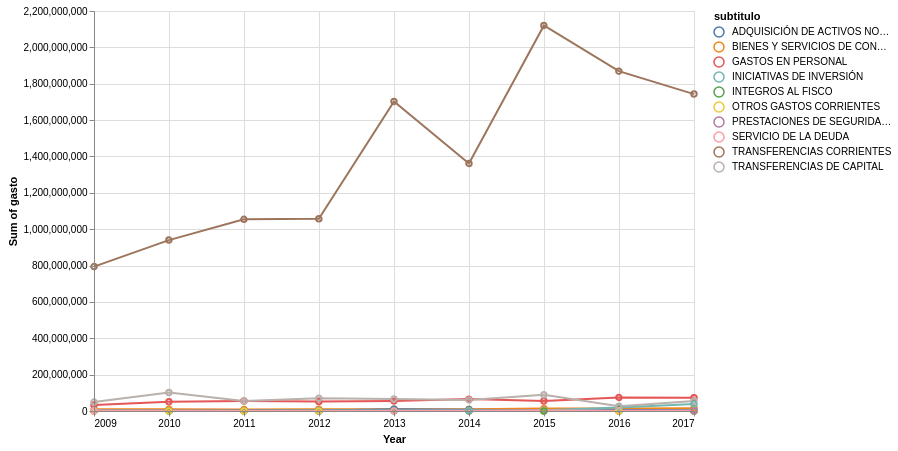

In [57]:
partida_chart.encode(color='subtitulo:N') + partida_chart.mark_point().encode(color='subtitulo:N')

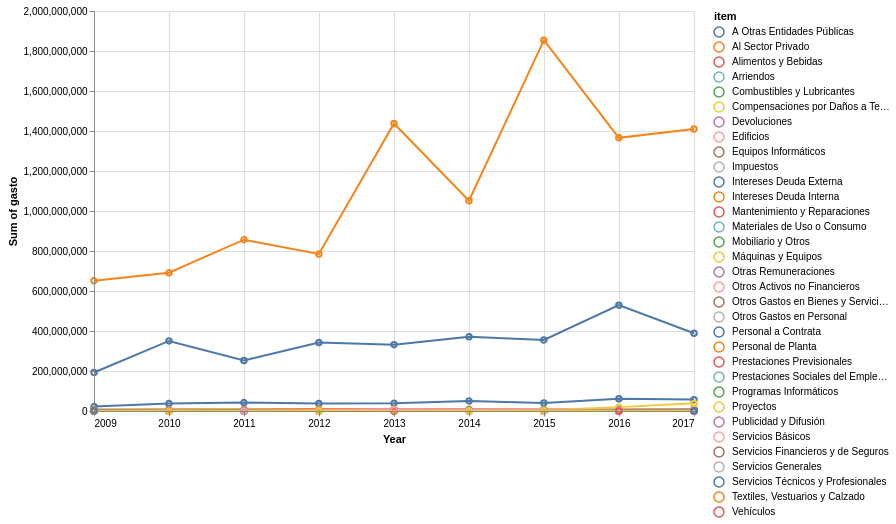

In [59]:
partida_chart.encode(color='item:N') + partida_chart.mark_point().encode(color='item:N')